# SageMaker - Built-in Algorithm
---

In this demonstration notebook, I will utilize the **built-in algorithms** provided by SageMaker. This way of building, training ML model is preferred way and optimize for costing instead of spinning up the large instance from the get-go.

**Amazon SageMaker** provides a suite of built-in algorithms, pre-trained models, and pre-built solution templates to help data scientists and machine learning practitioners get started on training and deploying machine learning models quickly. For someone who is new to SageMaker, choosing the right algorithm for your particular use case can be a challenging task. 

For full list of built-in algorithm, please refer to [SageMaker documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/algos.html).

## Set up
---
Ensure that **sagemaker** and **boto3** libraries are up-to-date.

In [2]:
%pip install awscli sagemaker boto3 botocore --quiet --upgrade --root-user-action=ignore

Note: you may need to restart the kernel to use updated packages.


## Load dataset and basic feature engineering
---

This code is reusable from previous notebook.

In [3]:
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', None)

In [4]:
df = pd.read_csv('../data/Insurance_FraudulentAutoInsuranceClaims_100k.csv')
print(df.shape)
display(df.head(3))

(100000, 23)


,first_name,last_name,date_of_birth,incident_severity,num_vehicles_involved,num_injuries,num_witnesses,police_report_available,injury_claim,vehicle_claim,incident_hour,customer_age,policy_deductable,policy_annual_premium,num_claims_past_year,EVENT_LABEL,EVENT_TIMESTAMP,EVENT_ID,ENTITY_TYPE,ENTITY_ID,policy_id,incident_type,LABEL_TIMESTAMP
0,Jose,Haynes,1927-10-16,5.0,2.0,2.0,1.0,0.0,12986.0,4375.0,15.0,43.0,666.0,2995.0,5.0,legit,2022-07-13T10:03:22Z,b4b09066-de78-40d9-bb54-498fee1770c5,customer,a612-85445302,b4b09066-de78-40d9-bb54-498fee1770c5,collision,2023-03-06T15:05:50Z
1,Vicki,Stark,1952-09-20,4.0,3.0,5.0,2.0,0.0,6065.0,5941.0,10.0,45.0,649.0,1535.0,4.0,legit,2023-02-03T02:48:21Z,d2ccfe0a-e65b-4983-bbd8-de73506f0bca,customer,c786-86718442,d2ccfe0a-e65b-4983-bbd8-de73506f0bca,theft,2023-03-06T15:05:50Z
2,Breanna,Kline,1984-05-14,4.0,3.0,3.0,2.0,0.0,12017.0,4712.0,22.0,30.0,436.0,3043.0,5.0,legit,2022-11-19T03:22:35Z,cd4084d4-717d-456b-baa9-bae079f80aaf,customer,b340-10389704,cd4084d4-717d-456b-baa9-bae079f80aaf,collision,2023-03-06T15:05:50Z


In [5]:
df.loc[:, 'EVENT_TIMESTAMP'] = pd.to_datetime(pd.to_datetime(df['EVENT_TIMESTAMP']).dt.strftime('%Y-%m-%d'))
df.loc[:, 'date_of_birth'] = pd.to_datetime(df['date_of_birth'])
df.loc[:, 'age'] = df['EVENT_TIMESTAMP'].apply(lambda x: x.year) - df['date_of_birth'].apply(lambda x: x.year)
df.drop(['LABEL_TIMESTAMP', 'ENTITY_TYPE'], axis=1, inplace=True)
df.drop(['EVENT_TIMESTAMP', 'ENTITY_ID', 'EVENT_ID'], axis=1, inplace=True)
df.drop(['date_of_birth', 'first_name', 'last_name'], axis=1, inplace=True)

In [6]:
target_col = 'EVENT_LABEL'
df['is_fraud'] = df[target_col].map({'fraud': 1, 'legit': 0})
df.drop([target_col], axis=1, inplace=True)
target_col = 'is_fraud' 

In [7]:
_tmp = pd.get_dummies(df['incident_type'], drop_first=True, dtype='int')
full_df = pd.concat([df.drop(['policy_id', 'incident_type'], axis=1), _tmp], axis=1)

In [8]:
full_df.head()

,incident_severity,num_vehicles_involved,num_injuries,num_witnesses,police_report_available,injury_claim,vehicle_claim,incident_hour,customer_age,policy_deductable,policy_annual_premium,num_claims_past_year,age,is_fraud,collision,theft
0,5.0,2.0,2.0,1.0,0.0,12986.0,4375.0,15.0,43.0,666.0,2995.0,5.0,95,0,1,0
1,4.0,3.0,5.0,2.0,0.0,6065.0,5941.0,10.0,45.0,649.0,1535.0,4.0,71,0,0,1
2,4.0,3.0,3.0,2.0,0.0,12017.0,4712.0,22.0,30.0,436.0,3043.0,5.0,38,0,1,0
3,5.0,2.0,3.0,2.0,0.0,10015.0,4120.0,13.0,41.0,640.0,3197.0,4.0,82,0,1,0
4,5.0,2.0,1.0,1.0,0.0,10962.0,3255.0,14.0,46.0,593.0,3738.0,3.0,4,0,1,0


## Build model using XGBoost on SageMaker
---

One thing about using **Amazon SageMaker XGBoost**, it can train on data in either a CSV or LibSVM format. 

For this demonstration, I'll stick with CSV. The requirement for using are;
- Have the predictor variable in the first column
- Not have a header row

For more information, please refer to this [documentation](https://sagemaker.readthedocs.io/en/stable/frameworks/xgboost/using_xgboost.html).

### Split data and save in acceptable format by SageMaker XGBoost

In [9]:
import sagemaker

S3_BUCKET_NM = sagemaker.Session().default_bucket()  # change this to fit your S3 bucket name
S3_PREFIX = 'built-in-algorithm/auto-insurance-fraud-claim'  # change this to fit your S3 key

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


In [10]:
from sklearn.model_selection import StratifiedShuffleSplit

X_df = full_df.drop([target_col], axis=1)
y_df = full_df[target_col]
train_test_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_idx, test_idx in train_test_split.split(X_df, y_df):
    train_df = full_df.loc[train_idx]
    test_df = full_df.loc[test_idx]

    
X_train_df = train_df.drop([target_col], axis=1)
y_train_df = train_df[target_col]
train_val_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_idx, val_idx in train_val_split.split(X_train_df, y_train_df):
    train_df = full_df.loc[train_idx]
    val_df = full_df.loc[val_idx]
    
print(train_df.shape, val_df.shape, test_df.shape)

(64000, 16) (16000, 16) (20000, 16)


In [11]:
fix_cols = [
    'is_fraud', 'incident_severity', 'num_vehicles_involved', 'num_injuries', 'num_witnesses', 
    'police_report_available', 'injury_claim', 'vehicle_claim', 'incident_hour', 
    'customer_age', 'policy_deductable', 'policy_annual_premium', 'num_claims_past_year', 'collision', 'theft'
]

In [12]:
xgb_train_df = train_df[fix_cols]
xgb_val_df = val_df[fix_cols]
xgb_test_df = test_df[fix_cols]
display(xgb_train_df.head(2))
display(xgb_val_df.head(2))
display(xgb_test_df.head(2))

,is_fraud,incident_severity,num_vehicles_involved,num_injuries,num_witnesses,police_report_available,injury_claim,vehicle_claim,incident_hour,customer_age,policy_deductable,policy_annual_premium,num_claims_past_year,collision,theft
9022,0,5.0,2.0,3.0,2.0,0.0,9746.0,4621.0,11.0,36.0,600.0,1824.0,6.0,0,1
52785,0,4.0,2.0,4.0,2.0,0.0,13003.0,4436.0,11.0,40.0,578.0,3190.0,3.0,0,0


,is_fraud,incident_severity,num_vehicles_involved,num_injuries,num_witnesses,police_report_available,injury_claim,vehicle_claim,incident_hour,customer_age,policy_deductable,policy_annual_premium,num_claims_past_year,collision,theft
67757,0,6.0,2.0,2.0,2.0,0.0,10148.0,4369.0,17.0,45.0,509.0,3111.0,4.0,1,0
66182,0,6.0,2.0,4.0,1.0,0.0,12138.0,4353.0,5.0,59.0,438.0,2953.0,4.0,1,0


,is_fraud,incident_severity,num_vehicles_involved,num_injuries,num_witnesses,police_report_available,injury_claim,vehicle_claim,incident_hour,customer_age,policy_deductable,policy_annual_premium,num_claims_past_year,collision,theft
78226,0,4.0,2.0,4.0,1.0,0.0,12212.0,5026.0,5.0,42.0,306.0,2279.0,5.0,1,0
20397,0,5.0,2.0,4.0,2.0,0.0,7157.0,5545.0,12.0,48.0,757.0,2345.0,5.0,0,0


In [13]:
xgb_train_df.to_csv(f's3://{S3_BUCKET_NM}/{S3_PREFIX}/xgb_train/train.csv', index=False, header=False)
xgb_val_df.to_csv(f's3://{S3_BUCKET_NM}/{S3_PREFIX}/xgb_val/validation.csv', index=False, header=False)
xgb_test_df.to_csv(f's3://{S3_BUCKET_NM}/{S3_PREFIX}/xgb_test/test.csv', index=False, header=False)

### Retrieve XGBoost Container and training

In [14]:
import sagemaker
import boto3

sm_session = sagemaker.Session()
REGION_NM = sm_session.boto_region_name
ROLE_ARN = sagemaker.get_execution_role()

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


Define `TrainingInput` function as a pointer to the data files in Amazon S3.

In [15]:
from sagemaker.inputs import TrainingInput
from sagemaker.serializers import CSVSerializer


s3_input_train = TrainingInput(
    s3_data='s3://{}/{}/xgb_train/'.format(S3_BUCKET_NM, S3_PREFIX), content_type='csv'
)

s3_input_validation = TrainingInput(
    s3_data="s3://{}/{}/xgb_val/".format(S3_BUCKET_NM, S3_PREFIX), content_type='csv'
)

In [17]:
container = sagemaker.image_uris.retrieve(
    'xgboost', REGION_NM, 'latest'
)

sm_xgb = sagemaker.estimator.Estimator(
    container,
    ROLE_ARN,
    instance_count=1,
    instance_type='ml.m5.xlarge',
    output_path=f's3://{S3_BUCKET_NM}/{S3_PREFIX}/xgb_output/',
    sagemaker_session=sm_session,
)

sm_xgb.set_hyperparameters(
    verbosity=0,
    objective='binary:logistic',
    num_round=100,
)

sm_xgb.fit({
    'train': s3_input_train, 
    'validation': s3_input_validation
})

INFO:sagemaker:Creating training-job with name: xgboost-2023-11-10-11-41-31-369


2023-11-10 11:41:31 Starting - Starting the training job...
2023-11-10 11:41:47 Starting - Preparing the instances for training......
2023-11-10 11:42:40 Downloading - Downloading input data...
2023-11-10 11:43:30 Training - Training image download completed. Training in progress...Arguments: train
[2023-11-10:11:43:40:INFO] Running standalone xgboost training.
[2023-11-10:11:43:40:INFO] File size need to be processed in the node: 5.11mb. Available memory size in the node: 8242.43mb
[2023-11-10:11:43:40:INFO] Determined delimiter of CSV input is ','
[11:43:40] S3DistributionType set as FullyReplicated
[11:43:40] 64000x14 matrix with 896000 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2023-11-10:11:43:40:INFO] Determined delimiter of CSV input is ','
[11:43:40] S3DistributionType set as FullyReplicated
[11:43:40] 16000x14 matrix with 224000 entries loaded from /opt/ml/input/data/validation?format=csv&label_column=0&delimiter=,
[11:43:40] src/tree/u

### Model deployment
---

The benefit of using **sagemaker** is we can deploy the trained model within the notebook with one-line of code. We can specify small or large instances and multiple instances (depends on the workload) without managing the network connection.

In this demonstration, I will deploy the trained model onto **real-time endpoint**.

There are multiple ways to deploy a model (i.e., batch prediction, real-time prediction), for the list and how-to, please refer to the [documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/how-it-works-deployment.html).

In [18]:
sm_xgb_predictor = sm_xgb.deploy(
    initial_instance_count=1, instance_type='ml.m5.xlarge', serializer=CSVSerializer()
)

INFO:sagemaker:Creating model with name: xgboost-2023-11-10-11-46-04-765
INFO:sagemaker:Creating endpoint-config with name xgboost-2023-11-10-11-46-04-765
INFO:sagemaker:Creating endpoint with name xgboost-2023-11-10-11-46-04-765


----!

In [20]:
pred = sm_xgb_predictor.predict(xgb_test_df.to_numpy()[:, 1:]).decode('utf-8').split(',')
predictions = np.array([float(num) for num in pred])

Quickly look at the distribution of probability

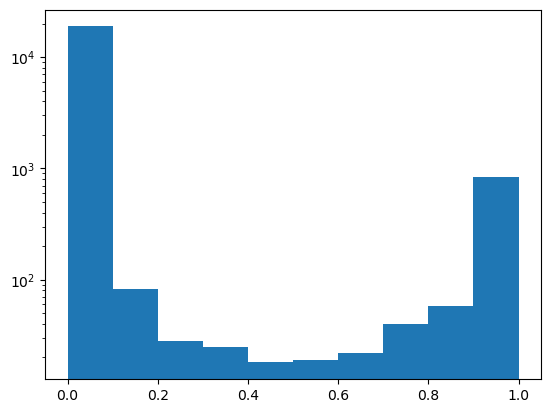

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist(predictions)
plt.yscale("log")
plt.show();

### Evaluation

In [22]:
from sklearn.metrics import f1_score, recall_score, precision_score, confusion_matrix, classification_report
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score

pd.crosstab(
    index=xgb_test_df.iloc[:, 0],
    columns=np.round(predictions),
    rownames=["actual"],
    colnames=["predictions"],
)

predictions,0.0,1.0
actual,,
0,18970,21
1,56,953


In [23]:
model_eval = {
    'model': [],
    'roc_auc_score': [],
    'precision': [],
    'recall': [],
    'f1_score': []
}

def add_model_eval(model, roc_auc_score, precision, recall, f1_score):
    model_eval['model'].append(model)
    model_eval['roc_auc_score'].append(f'{roc_auc_score: .4f}')
    model_eval['precision'].append(f'{precision: .4f}')
    model_eval['recall'].append(f'{recall: .4f}')
    model_eval['f1_score'].append(f'{f1_score: .4f}')
    return model_eval
    
def view_models_eval(model_eval: dict=model_eval, sort:bool =False):
    eval_df = pd.DataFrame(model_eval)
    
    if sort:
        eval_df = eval_df.sort_values(by=['recall', 'f1_score'], ascending=[False, False])
    
    display(eval_df)
    return eval_df

In [24]:
add_model_eval(
    'SM - XGBoost', 
    roc_auc_score(xgb_test_df.iloc[:, 0], np.round(predictions)),
    precision_score(xgb_test_df.iloc[:, 0], np.round(predictions)),
    recall_score(xgb_test_df.iloc[:, 0], np.round(predictions)), 
    f1_score(xgb_test_df.iloc[:, 0], np.round(predictions))
)
eval_df = view_models_eval(model_eval)

,model,roc_auc_score,precision,recall,f1_score
0,SM - XGBoost,0.9717,0.9784,0.9445,0.9612


<div class="alert alert-block alert-info">
    <b>Note:</b> You should <u>delete</u> the model endpoint if you are no longer using it, as it will cause incurring charged!
</div>

## Build model using Scikit-learn on SageMaker
---

In this section, I will demonstrate how to use **scikit-learn** on SageMaker.

For information on scikit-learn container on AWS, please refer to this [github repository](https://github.com/aws/sagemaker-scikit-learn-container).

### Split data and upload to Amazon S3
---
When we want to train the model using SageMaker, we will need to reference the file on Amazon S3.

In [25]:
from sklearn.model_selection import StratifiedShuffleSplit

X_df = full_df.drop([target_col], axis=1)
y_df = full_df[target_col]
train_test_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_idx, test_idx in train_test_split.split(X_df, y_df):
    train_df = full_df.loc[train_idx]
    test_df = full_df.loc[test_idx]

    
X_train_df = train_df.drop([target_col], axis=1)
y_train_df = train_df[target_col]
train_val_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_idx, val_idx in train_val_split.split(X_train_df, y_train_df):
    train_df = full_df.loc[train_idx]
    val_df = full_df.loc[val_idx]
    
print(train_df.shape, val_df.shape, test_df.shape)

(64000, 16) (16000, 16) (20000, 16)


In [26]:
train_df.to_csv(f's3://{S3_BUCKET_NM}/{S3_PREFIX}/train/train.csv', index=False, header=True)
val_df.to_csv(f's3://{S3_BUCKET_NM}/{S3_PREFIX}/val/validation.csv', index=False, header=True)
test_df.to_csv(f's3://{S3_BUCKET_NM}/{S3_PREFIX}/test/test.csv', index=False, header=True)

### Prepare a Scikit-learn Training script
---

The training script will be similar script you might run outside of SageMaker. Because Scikit-learn library contains many algorithms, you will need to specify that inside the training script.

Please refer to the documentation [here](https://docs.aws.amazon.com/sagemaker/latest/dg/pre-built-docker-containers-scikit-learn-spark.html) and check the latest version of scikit-learn [here](https://docs.aws.amazon.com/sagemaker/latest/dg/sklearn.html).

In [27]:
tmp_df = pd.read_csv(f's3://{S3_BUCKET_NM}/{S3_PREFIX}/train/train.csv', header=0)
tmp_df.head()

,incident_severity,num_vehicles_involved,num_injuries,num_witnesses,police_report_available,injury_claim,vehicle_claim,incident_hour,customer_age,policy_deductable,policy_annual_premium,num_claims_past_year,age,is_fraud,collision,theft
0,5.0,2.0,3.0,2.0,0.0,9746.0,4621.0,11.0,36.0,600.0,1824.0,6.0,4,0,0,1
1,4.0,2.0,4.0,2.0,0.0,13003.0,4436.0,11.0,40.0,578.0,3190.0,3.0,82,0,0,0
2,5.0,2.0,5.0,2.0,0.0,10527.0,3950.0,12.0,33.0,551.0,2628.0,4.0,106,0,0,0
3,5.0,2.0,4.0,2.0,0.0,10142.0,4942.0,12.0,44.0,550.0,3879.0,3.0,33,0,0,1
4,5.0,2.0,4.0,2.0,0.0,10134.0,4748.0,13.0,38.0,514.0,2348.0,4.0,26,0,1,0


In [28]:
%%writefile scikit_learn_rf.py
from __future__ import print_function

import argparse
import joblib
import os
import pandas as pd
from sklearn.ensemble import RandomForestClassifier


if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    
    # Hyperparameters section for RandomForestClassifier algorithm
    parser.add_argument('--n_estimators', type=int, default=100)
    parser.add_argument('--max_depth', type=int, default=4)
    parser.add_argument('--verbose', type=int, default=0)
    parser.add_argument('--random_state', type=int, default=42)
    

    # Sagemaker specific arguments. Defaults are set in the environment variables.
    parser.add_argument('--output-data-dir', type=str, default=os.environ['SM_OUTPUT_DATA_DIR'])
    parser.add_argument('--model-dir', type=str, default=os.environ['SM_MODEL_DIR'])
    parser.add_argument('--train', type=str, default=os.environ['SM_CHANNEL_TRAIN'])

    args = parser.parse_args()

    # Take the set of files and read them all into a single pandas dataframe
    input_files = [os.path.join(args.train, file) for file in os.listdir(args.train)]
    if len(input_files) == 0:
        raise ValueError(('There are no files in {}.\n' +
                          'This usually indicates that the channel ({}) was incorrectly specified,\n' +
                          'the data specification in S3 was incorrectly specified or the role specified\n' +
                          'does not have permission to access the data.').format(args.train, "train"))
        
    # based on our save dataset, we have header, and target column name = 'is_fraud'
    raw_data = [pd.read_csv(file, header=0, engine="python") for file in input_files]
    train_data = pd.concat(raw_data)
    target_col = 'is_fraud'
    X_train = train_data.drop([target_col], axis=1)
    y_train = train_data.loc[:, target_col]

    # get the hyperparameters passing through the script
    n_estimators = args.n_estimators
    max_depth = args.max_depth
    verbose = args.verbose
    random_state = args.random_state
    n_jobs = -1
    
    clf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        verbose=verbose,
        random_state=random_state,
        n_jobs=n_jobs
    )
    clf = clf.fit(X_train, y_train)

    # Print the coefficients of the trained classifier, and save the coefficients
    joblib.dump(clf, os.path.join(args.model_dir, "model.joblib"))


def model_fn(model_dir):
    """Deserialized and return fitted model

    Note that this should have the same name as the serialized model in the main method
    """
    clf = joblib.load(os.path.join(model_dir, "model.joblib"))
    return clf

Overwriting scikit_learn_rf.py


### Create a SageMaker SKLearn Estimator
---
To run our training script, we need to construct `sagemaker.sklearn.estimator.sklearn`.

In [31]:
from sagemaker.sklearn.estimator import SKLearn

FRAMEWORK_VERSION = '1.2-1'
script_path = 'scikit_learn_rf.py'

skl_rf = SKLearn(
    entry_point=script_path,
    framework_version=FRAMEWORK_VERSION,
    instance_type='ml.c5.xlarge',
    role=ROLE_ARN,
    sagemaker_session=sm_session,
    hyperparameters={
        'n_estimators': 100,
        'max_depth': 5,
        'verbose': 0,
        'random_state': 42,
    },
    container_log_level=50,  # remove this to see the other log level within the container executions
)

In [32]:
skl_rf.fit({
    'train': f's3://{S3_BUCKET_NM}/{S3_PREFIX}/train/'
})


INFO:sagemaker:Creating training-job with name: sagemaker-scikit-learn-2023-11-10-11-52-57-291


Using provided s3_resource
2023-11-10 11:52:57 Starting - Starting the training job...
2023-11-10 11:53:13 Starting - Preparing the instances for training......
2023-11-10 11:54:15 Downloading - Downloading input data...
2023-11-10 11:54:50 Training - Training image download completed. Training in progress....
2023-11-10 11:55:11 Uploading - Uploading generated training model
2023-11-10 11:55:11 Completed - Training job completed
..Training seconds: 56
Billable seconds: 56


### Model Deployment

In [33]:
skl_rf_predictor = skl_rf.deploy(initial_instance_count=1, instance_type="ml.c5.xlarge")

INFO:sagemaker:Creating model with name: sagemaker-scikit-learn-2023-11-10-11-55-48-280
INFO:sagemaker:Creating endpoint-config with name sagemaker-scikit-learn-2023-11-10-11-55-48-280
INFO:sagemaker:Creating endpoint with name sagemaker-scikit-learn-2023-11-10-11-55-48-280


---!

### Evaluation and validate

In [34]:
pred = skl_rf_predictor.predict(test_df.drop(['is_fraud'], axis=1))

In [35]:
add_model_eval(
    'SM - SK-LEARN - RandomForest', 
    roc_auc_score(test_df['is_fraud'], pred),
    precision_score(test_df['is_fraud'], pred),
    recall_score(test_df['is_fraud'], pred),
    f1_score(test_df['is_fraud'], pred)
)
eval_df = view_models_eval(model_eval)

,model,roc_auc_score,precision,recall,f1_score
0,SM - XGBoost,0.9717,0.9784,0.9445,0.9612
1,SM - SK-LEARN - RandomForest,0.6838,1.0000,0.3677,0.5377


<div class="alert alert-block alert-info">
    <b>Note:</b> You should <u>delete</u> the model endpoint if you are no longer using it, as it will cause incurring charged!
</div>